# Tutorial: skultrafast.dataset

skultrafast is a package mainly for working with time-resolved spectra. The notebook shows how to
use the new dataset-class to work with such a spectra and to fit it with a exponetial model. First we import
the necessary modules and configure matplotlib to show inline graphics.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
from skultrafast.dataset import DataSet
import skultrafast
from skultrafast import data_io
print(skultrafast.__file__)
skultrafast.__version__

pyopencl not found, using numba-basefunctions
c:\users\tills\onedrive\dokumente\skultrafast_git\skultrafast\__init__.py


'0.2.1+52.ge2ee80c.dirty'

## Creating a DataSet
In this tuturial we use the example data which is provided by *skultrafast*. 

In [3]:
wavelengths, t_ps, data_mOD = data_io.load_example()

Lets look at the constructor of the `DataSet` class:

In [4]:
help(DataSet.__init__)

Help on function __init__ in module skultrafast.dataset:

__init__(self, wl, t, data, err=None, name=None, freq_unit='nm', disp_freq_unit=None, auto_plot=True)
    Class for working with time-resolved spectra. If offers methods for
    analyzing and pre-processing the data. To visualize the data,
    each `DataSet` object has an instance of an `DataSetPlotter` object
    accessible under `plot`.
    
    Parameters
    ----------
    wl : array of shape(n)
        Array of the spectral dimension
    t : array of shape(m)
        Array with the delay times.
    data : array of shape(n, m)
        Array with the data for each point.
    err : array of shape(n, m) or None (optional)
        Contains the std err of the data, can be `None`.
    name : str (optional)
        Identifier for data set.
    freq_unit : 'nm' or 'cm' (optional)
        Unit of the wavelength array, default is 'nm'.
    disp_freq_unit : 'nm','cm' or None (optional)
        Unit which is used by default for plotting

As we see, we have all the necessay variables, additionlly we can name the dataset. Since the `freq_unit` defaults to 'nm' we don't need to supply this argument.

In [5]:
ds = DataSet(wavelengths, t_ps, data_mOD, name="Al(tpfc)(py)_2")

## Overview

To get an general idea of a transient spectra is to plot some data.  All plotting functions are in the `DataSet.plot` object, which is an instance of `DataSetPlotter`. The plotting functions are using the `disp_freq_unit` of the dataset as frequency scale by default. This can be changed by changing the `disp_freq_unit` of the `DataSetPlotter` object. 

In [6]:
ds.plot.disp_freq_unit = 'nm' # does nothing, since 'nm' is the default
# ds.plot.disp_freq_unit = 'cm' would use wavenumbers

First, we want to check if the dataset is corrected for dispersion. For that we plot a colormap around the time-zero. 

(-2, 2)

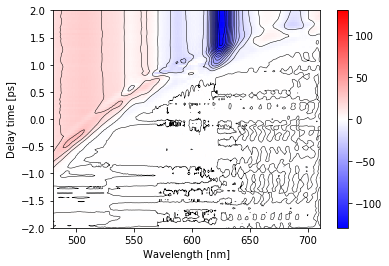

In [7]:
ds.plot.map(symlog=0, con_step=10., con_filter=(3, 10))
plt.ylim(-2, 2)

Evidently, the dataset is not corrected for dispersion. Since it is easier to work with a dispersion corrected dataset, we try to get an estimate of the dispersion using the data directly. 

*skultrafast* does this by first using a simple heuristic for determining the time-zero for each transient. The resulting dispersion curve is then fitted with a polynomial, using a robust fitting method. More details are given in the documentation.

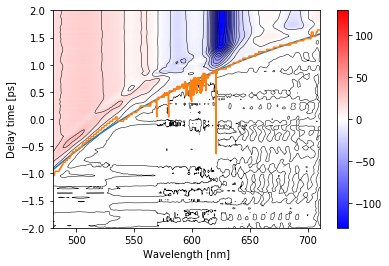

In [8]:
# First calculate and plot the estimate.
res = ds.estimate_dispersion(heuristic_args=(1.5,), deg=2)
ds.plot.map(symlog=0, con_step=10., con_filter=(3, 10))
plt.ylim(-2, 2)
plt.plot(ds.wavelengths, res.polynomial(ds.wavenumbers)) #The polynomial is defined in wavenumbers
plt.plot(ds.wavelengths, res.tn)

By default, *skultrafast* uses a very simple heuristic to find the time-zero. It looks for the earliest value above a given limit in each transient, and therefore underestimates the time-zero systematically. Therefore we slightly shift the time-zero. 

This generallay works surprinsingly well. But if the exact time-zero is necessary, I recommend to try other methods or measure the dispersion directly.

**WARNING** The cell below changes the dataset inplace. Therefore repeated calls to the cell will shift the time-zero even more.

In [9]:
new_ds = res.correct_ds #warning, this is no copy
new_ds.t -= 0.2

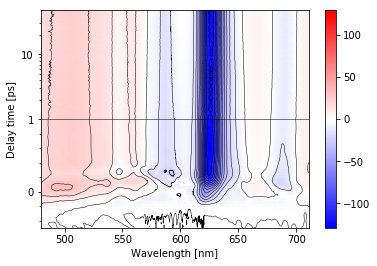

In [10]:
new_ds.plot.map(con_step=10., con_filter=(3, 5))

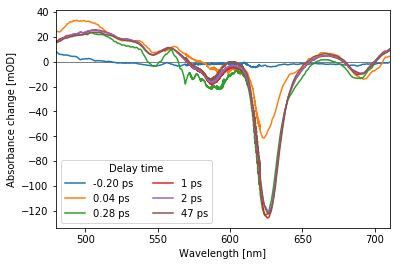

In [13]:
res.correct_ds.plot.spec([-.2, 0.05, 0.3, 1, 2, 150])

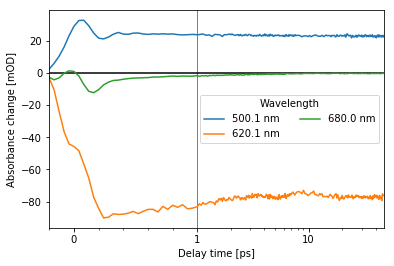

In [14]:
res.correct_ds.plot.trans([500, 620, 680], symlog=1)

## Exponential fitting

___

__Note: The section is likly to change, since the current interface is still very rough.__

---

Fitting a decay-associated spectra is a one-liner in skultrafast. If the dataset is dispersion corrected,
only a starting guess is necessay.

In [15]:
fit_res = new_ds.fit_exp([-0.0, 0.05, 2, 20, 10000])
fit_res.lmfit_res.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
p0   0.08051     -inf      inf 0.0001505     True     None     None
t0     1.279      0.1      inf 0.006418     True     None     None
t1     14.15      0.1      inf   0.1629     True     None     None
t2     1e+04      0.1      inf        0    False     None     None
w     0.1552        0      inf 0.0001201     True     None     None


### Plotting the DAS, using old skultrafast functions

(-1, 10)

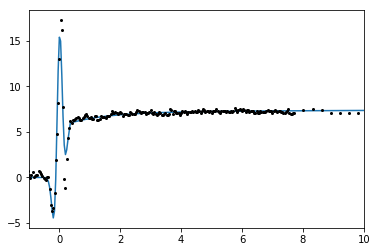

In [16]:
plt.plot(new_ds.t-fit_res.lmfit_res.params['p0'].value, fit_res.fitter.model[:, 200])
plt.plot(new_ds.t-fit_res.lmfit_res.params['p0'].value, fit_res.fitter.data[:, 200], 'o', color='k', ms=2)
plt.xlim(-1, 10)

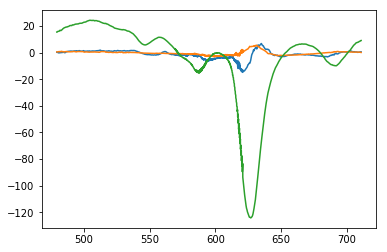

In [17]:
plt.plot(new_ds.wavelengths, fit_res.fitter.c[:, :3])

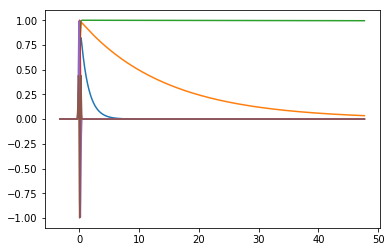

In [18]:
plt.plot(new_ds.t, fit_res.fitter.x_vec)

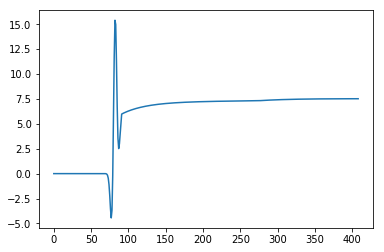

In [28]:
f = fit_res.fitter
plt.plot(np.dot(f.c, f.x_vec.T).T[:, 200])

In [ ]:
f.x_